<img src="spam.jpg" />

# Spam Classifier

### Objectif : Concevoir un classifieur de détection automatique de SPAM.

La collection SMS Spam est un ensemble de messages SMS marqués qui ont été collectés pour la recherche sur les SMS Spam. Elle contient un ensemble de messages SMS en anglais de 5 574 messages, étiquetés selon qu'ils sont ham (légitimes) ou spam.

## Sommaire

### [EDA](#chapter1)
* [Valeurs en double](#duplicate)
* [Nettoyage de l'encoding](#cleaning_encoding)

### [Features extraction](#features_extraction)
* [Longueur du texte](#length)
* [Nombre de mots](#words_count)
* [Nombre de majuscules](#uppercases_count)
* [Nombre de minuscules](#lowercases_count)
* [Présence d'un numéro de téléphone](#phone_number)
* [Présence d'une url ou d'un mail](#url_or_mail)
* [Nombre de caractères spéciaux](#special_char_count)
* [Wordcloud](#wordcloud)

### [Preprocessing](#preprocessing)
### [Normalise](#normalise)
### [Pipeline ML](#pipeline_ml)
### [Prédiction](#prediction)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import string

In [2]:
df = pd.read_csv('spam.csv',encoding = "latin-1")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
df.drop(['Unnamed: 2', 'Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
df.rename(columns={"v1": "target", "v2": "text"},inplace=True)

In [5]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.describe()

,target,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


# EDA <a class="anchor" id="chapter1"></a>

In [7]:
df['target'].value_counts()

ham     4825
spam     747
Name: target, dtype: int64

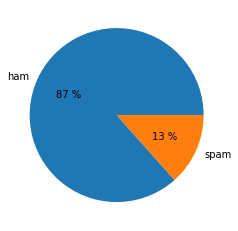

In [8]:
plt.pie(df["target"].value_counts(),labels=["ham","spam"],autopct="%.0f %%")
plt.show()

### Valeurs en double <a class="anchor" id="duplicate"></a>

In [9]:
df.duplicated().value_counts()

False    5169
True      403
dtype: int64

In [10]:
df.drop_duplicates(inplace=True) # (pour Noli,inplace supprimer directement sur la df)

In [11]:
df.duplicated().value_counts() # Verification apres suppression

False    5169
dtype: int64

### Nettoyage de l'encoding <a class="anchor" id="cleaning_encoding"></a>

In [12]:
def text_cleaning_encoding(text):
    text = re.sub('&lt;#&gt;',"",text) #Removing square brackets from the text
    return(text) 

In [13]:
df['text'] = df['text'].apply(text_cleaning_encoding)

# Features extraction <a class="anchor" id="features_extraction"></a>

#### Longueur du texte <a class="anchor" id="length"></a>

In [14]:
df['length'] = df['text'].str.len()

In [15]:
df.head() # Verification

,target,text,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


#### Nombre de mots <a class="anchor" id="words_count"></a>

In [16]:
df['words_count'] = df['text'].apply(lambda x: len(x.split(" ")))

In [17]:
df.head() # Verification

,target,text,length,words_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28
3,ham,U dun say so early hor... U c already then say...,49,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13


#### Nombre de majuscules <a class="anchor" id="uppercases_count"></a>

In [18]:
df['uppercases_count'] = df['text'].str.findall(r'[A-Z]').str.len()

In [19]:
df.head() # Verification

,target,text,length,words_count,uppercases_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3
1,ham,Ok lar... Joking wif u oni...,29,6,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,10
3,ham,U dun say so early hor... U c already then say...,49,11,2
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,2


#### Nombre de minuscules <a class="anchor" id="lowercases_count"></a>

In [20]:
df['lowercases_count'] = df['text'].str.findall(r'[a-z]').str.len()

In [21]:
df.head()

,target,text,length,words_count,uppercases_count,lowercases_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3,80
1,ham,Ok lar... Joking wif u oni...,29,6,2,16
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,10,87
3,ham,U dun say so early hor... U c already then say...,49,11,2,31
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,2,45


#### Presence d'un numéro de téléphone <a class="anchor" id="phone_number"></a>

In [22]:
def isNumberSequenceInText(txt):
    if bool(re.search("(\d{2})", txt)):
        return 1
    else:
        return 0

In [23]:
df['number_sequence'] = df['text'].map(isNumberSequenceInText)

In [24]:
df.head() # Verification

,target,text,length,words_count,uppercases_count,lowercases_count,number_sequence
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3,80,0
1,ham,Ok lar... Joking wif u oni...,29,6,2,16,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,10,87,1
3,ham,U dun say so early hor... U c already then say...,49,11,2,31,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,2,45,0


In [25]:
df.groupby(['target'])['number_sequence'].sum()

target
ham      97
spam    580
Name: number_sequence, dtype: int64

Text(0.5, 1.0, 'le rapport ham/spam quand il y a au mois 2 chiffres de suites')

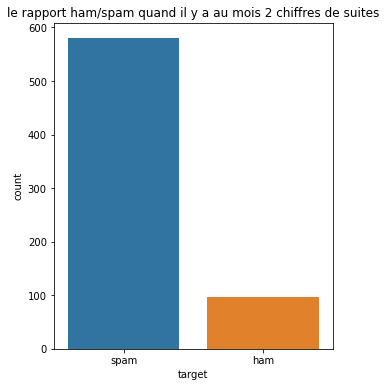

In [26]:
df1 = df[df['number_sequence'] == 1]
plt.figure(figsize=(5,6),)
sns.countplot(x=df1['target']).set_title('le rapport ham/spam quand il y a au mois 2 chiffres de suites')

#### Présence d'une url ou d'un mail <a class="anchor" id="url_or_mail"></a>

In [27]:
# Ancien ReGex -> \.[a-z]{2,3}(\.|\s|$)|(https?:\/\/|www\.)[a-zA-Z0-9-_\.]+

def isUrlMailInText(txt):
    if bool(re.search("((https?:\/\/|www\.)[a-zA-Z0-9-_\.]+)|(\w+@\w+)", txt)):
        return 1
    else:
        return 0

In [28]:
df['url_or_mail'] = df['text'].map(isUrlMailInText)

In [29]:
df.head() # Verification

,target,text,length,words_count,uppercases_count,lowercases_count,number_sequence,url_or_mail
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3,80,0,0
1,ham,Ok lar... Joking wif u oni...,29,6,2,16,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,10,87,1,0
3,ham,U dun say so early hor... U c already then say...,49,11,2,31,0,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,2,45,0,0


In [30]:
df.groupby(['target'])['url_or_mail'].sum()

target
ham       2
spam    103
Name: url_or_mail, dtype: int64

Text(0.5, 1.0, "Rapport ham/spam si présence d'une url ou d'un mail")

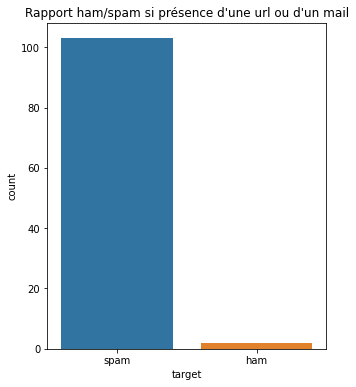

In [31]:
df1 = df[df['url_or_mail'] == 1]
plt.figure(figsize=(5,6),)
sns.countplot(x=df1['target']).set_title('Rapport ham/spam si présence d\'une url ou d\'un mail')

#### Nombre de caractères spéciaux <a class="anchor" id="special_char_count"></a>

In [32]:
# Modification de la fonction pour sortir des catégories
# categorie : nb de caracteres speciaux
# cat 1 : [1]
# cat 2 : [2-6]
# cat 3 : [7-12]
# cat 4 : [13+]

def countSpecialCharInText(txt):
    category = 0
    nbSpecialChar = len(re.findall("[$&+:;=?@#|'<>^*()%!-]", txt))
    if nbSpecialChar == 1:
        category = 1
    elif nbSpecialChar > 1 and nbSpecialChar < 7:
        category = 2
    elif nbSpecialChar > 6 and nbSpecialChar < 13:
        category = 3
    elif nbSpecialChar > 12:
        category = 4
        
    return category

In [33]:
df['special_char_count'] = df['text'].map(countSpecialCharInText)

In [34]:
df.head() # Verification

,target,text,length,words_count,uppercases_count,lowercases_count,number_sequence,url_or_mail,special_char_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3,80,0,0,0
1,ham,Ok lar... Joking wif u oni...,29,6,2,16,0,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,10,87,1,0,2
3,ham,U dun say so early hor... U c already then say...,49,11,2,31,0,0,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,2,45,0,0,1


In [35]:
df[df['special_char_count'] == 0]

,target,text,length,words_count,uppercases_count,lowercases_count,number_sequence,url_or_mail,special_char_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3,80,0,0,0
1,ham,Ok lar... Joking wif u oni...,29,6,2,16,0,0,0
3,ham,U dun say so early hor... U c already then say...,49,11,2,31,0,0,0
6,ham,Even my brother is not like to speak with me. ...,77,16,2,58,0,0,0
17,ham,Eh u remember how 2 spell his name... Yes i di...,81,19,3,54,0,0,0
...,...,...,...,...,...,...,...,...,...
5561,ham,Get me out of this dump heap. My mom decided t...,70,15,8,45,0,0,0
5562,ham,Ok lor... Sony ericsson salesman... I ask shuh...,96,18,3,66,0,0,0
5563,ham,Ard 6 like dat lor.,19,5,1,12,0,0,0
5565,ham,Huh y lei...,12,3,1,6,0,0,0


In [36]:
cTabSpecialChar = pd.crosstab(df['target'], df['special_char_count'])

In [37]:
cTabSpecialChar

special_char_count,0,1,2,3,4
target,,,,,
ham,1933,1280,1219,74,10
spam,110,134,386,18,5


<AxesSubplot:xlabel='special_char_count', ylabel='Count'>

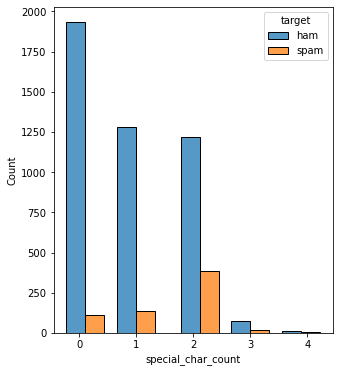

In [38]:
plt.figure(figsize=(5,6),)
sns.histplot(data=df, x="special_char_count", hue="target", multiple="dodge", shrink=3)

# Wordcloud <a class="anchor" id="wordcloud"></a>

#### Préparation

In [39]:
def text_cleaning(text):
    text = str(text).lower() #Converting text into lowercase
    text = re.sub('\[.*?\]','',text) #Removing square brackets from the text
    text = re.sub('https?://\S+|www\.\S+', '', text) #Removing links starting with (https or www)
    text = re.sub('<.*?>+','',text) #Removing <"text"> type of text
    text = re.sub("[%s]" % re.escape(string.punctuation),'',text) #Removing punctuations
    text = re.sub("\n",'',text) #Removing new lines
    text = re.sub('\w*\d\w*','',text) #Removing alphanumeric numbers
    text = re.sub('û÷',"'",text) # Remplacement caractères non encodés
    text = re.sub('åõ',"'",text) # Remplacement caractères non encodés
    return(text)

In [40]:
df['text'] = df['text'].apply(text_cleaning)

In [41]:
strHam = ""
strSpam = ""

for idx, series in df.iterrows():
    if series['target'] == 'ham': 
        strHam += series['text']
        strHam += " "
    else:
        strSpam += series['text']
        strSpam += " "

In [42]:
df['text'].head(25)

0     go until jurong point crazy available only in ...
1                               ok lar joking wif u oni
2     free entry in  a wkly comp to win fa cup final...
3           u dun say so early hor u c already then say
4     nah i dont think he goes to usf he lives aroun...
5     freemsg hey there darling its been  weeks now ...
6     even my brother is not like to speak with me t...
7     as per your request melle melle oru minnaminun...
8     winner as a valued network customer you have b...
9     had your mobile  months or more u r entitled t...
10    im gonna be home soon and i dont want to talk ...
11    six chances to win cash from  to  pounds txt  ...
12    urgent you have won a  week free membership in...
13    ive been searching for the right words to than...
14                    i have a date on sunday with will
15    xxxmobilemovieclub to use your credit click th...
16                                 oh kim watching here
17    eh u remember how  spell his name yes i di

In [43]:
strHam

"go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat ok lar joking wif u oni u dun say so early hor u c already then say nah i dont think he goes to usf he lives around here though even my brother is not like to speak with me they treat me like aids patent as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertune for all callers press  to copy your friends callertune im gonna be home soon and i dont want to talk about this stuff anymore tonight k ive cried enough today ive been searching for the right words to thank you for this breather i promise i wont take your help for granted and will fulfil my promise you have been wonderful and a blessing at all times i have a date on sunday with will oh kim watching here eh u remember how  spell his name yes i did he v naughty make until i v wet fine if that's the way u feel that's the way its gota b is that seriously how you spell his name i\x89'm going

<Figure size 432x288 with 0 Axes>

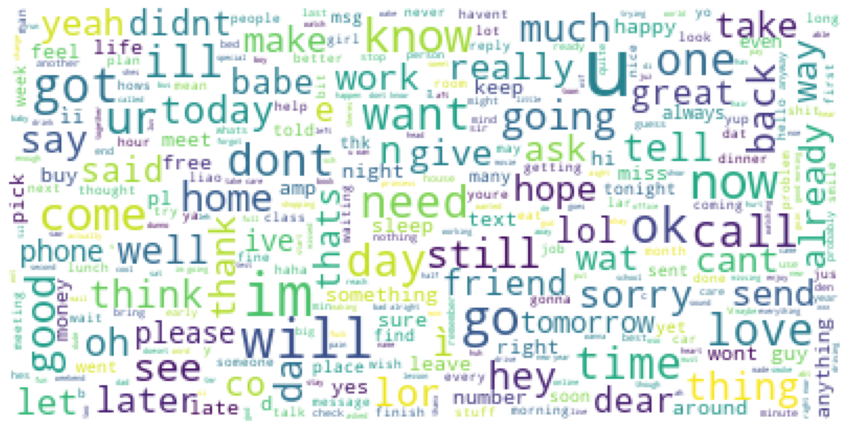

In [44]:
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud().generate(strHam)

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",max_words=len(strHam),max_font_size=40, relative_scaling=.5).generate(strHam)
plt.figure()
plt.figure( figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Wordcloud des Spam

<Figure size 432x288 with 0 Axes>

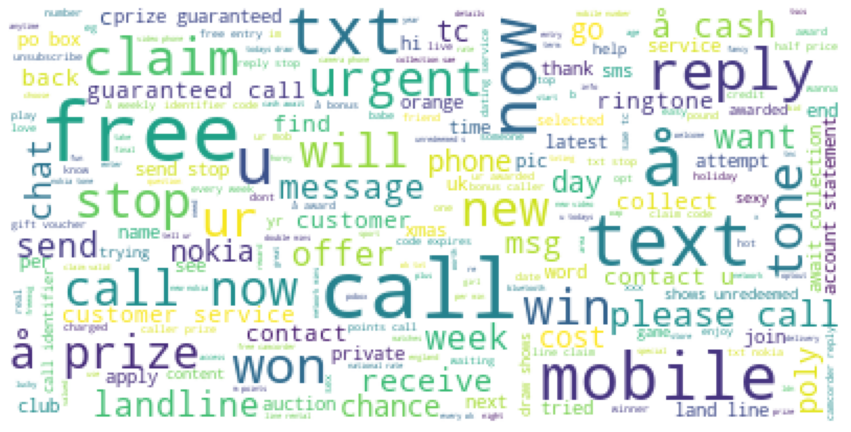

In [45]:
# Generate a word cloud image
wordcloud = WordCloud().generate(strSpam)

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",max_words=len(strSpam),max_font_size=40, relative_scaling=.5).generate(strSpam)
plt.figure()
plt.figure( figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

prize, urgent, free, mobile, please call, call now, cash, chat, win, txt, now, reply, phone, new, now, call, tone, claim, won, chance 

In [46]:
wordsList = ['prize','urgent','free','mobile','please','cash','chat','win','txt','reply','phone','new','now','call','tone','claim','won','chance']

In [47]:
def countWordsInText(txt):
    res = 0
    nb = 0
    for i in wordsList:
        nb += len(re.findall(r"\b" + i + r"\b", txt))
            
    if nb > 3:
        res = 1
    else:
        res = 0

    return res

In [48]:
for r in df['text']:
    print("-- ",r,countWordsInText(r))

--  go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat 0
--  ok lar joking wif u oni 0
--  free entry in  a wkly comp to win fa cup final tkts  may  text fa to  to receive entry questionstd txt ratetcs apply  0
--  u dun say so early hor u c already then say 0
--  nah i dont think he goes to usf he lives around here though 0
--  freemsg hey there darling its been  weeks now and no word back id like some fun you up for it still tb ok xxx std chgs to send å£ to rcv 0
--  even my brother is not like to speak with me they treat me like aids patent 0
--  as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertune for all callers press  to copy your friends callertune 0
--  winner as a valued network customer you have been selected to receivea å£ prize reward to claim call  claim code  valid  hours only 1
--  had your mobile  months or more u r entitled to update to the latest colour mobiles with camer

--  when i have stuff to sell ill tell you 0
--   urgent this is the  attempt to contact uu have won å£ call     callcost  mobilesvary maxå£  0
--  book which lesson then you msg me i will call up after work or sth im going to get specs my membership is  0
--  you have won a guaranteed å£ cash or a å£ prize to claim yr prize call our customer service representative on  between  1
--  macha dont feel upseti can assume your mindsetbelieve me one evening with me and i have some wonderful plans for both of uslet life begin againcall me anytime 0
--  oh is it send me the address 0
--  sfine anytime all the best with it 0
--  that is wondar full flim 0
--  ya even those cookies have jelly on them 0
--  the world is running and i am stillmaybe all are feeling the sameso be itor i have to admiti am madthen where is the correctionor let me call this is lifeand keep running with the worldmay be u r also runninglets run 0
--  got it it looks scrumptious daddy wants to eat you all night long 0
-- 

--  u sleeping now or you going to take haha i got spys wat me online checking n replying mails lor 0
--  claire here am havin borin time  am now alone u wanna cum over  chat now  hope  c u luv claire xx callså£ 0
--  bought one ringtone and now getting texts costing  pound offering more tones etc 0
--  yalru lyfu astne chikku bt innu mundhe lyf ali halla ke bilo marriageprogram edhae so lyf is nt yet ovr chikkuali vargu lyfu meow meowd 0
--  kinda first one gets in at twelve aah speak tomo 0
--   urgent your mobile no  won a å£ bonus caller prize on  this is the  attempt to reach you call  asap 1
--  ok good then i later come find ì c lucky i told ì to go earlier later pple take finish ì no more again 0
--  wat makes u thk ill fall down but actually i thk im quite prone  falls lucky my dad at home i ask him come n fetch me already 0
--  you  are guaranteed the latests nokia phone a  ipod  player or a å£ prize txt wordcollect to  tcllc nyusa   0
--  i wont touch you with out your permi

--  sicomo  plaid albumquite gdthe new  which is hilariousalso boughtåóbraindanceåóa compofstuff on aphex's abel 0
--  pls tell nelson that the bbs are no longer comin the money i was expecting aint coming 0
--  give her something to drink if she takes it and doesnt vomit then you her temp might drop if she unmits however let me know 0
--  think you sent the text to the home phone that cant display texts if you still want to send it his number is 0
--  every day i use to sleep after    so only 0
--  k ill call you when im close 0
--  u buy newspapers already 0
--  nope wif my sis lor aft bathing my dog then i can bathe looks like its going  rain soon 0
--  boo im on my way to my moms shes making tortilla soup yummmm 0
--  no management puzzeles 0
--  how did you find out in a way that didnt include all of these details 0
--  hi ya babe x u  bout me scammers getting smartthough this is a regular vodafone no if you respond you get further prem rate msgsubscription other nos used also bew

--  one day a crab was running on the sea shorethe waves came n cleared the footprints of the crab crab asked being my frnd y r u clearing my beautiful footprints waves replied a fox was following ur footprints to catch you thats y i cleared it off frndsship never lets u dwn  gud nyt 0
--  aight what time you want me to come up 0
--  slaaaaave  where are you  must i summon you to me all the time now  dont you wish to come to me on your own anymore 0
--  your bill at  is å£ so thats not bad 0
--  let me know how it changes in the next  it can even be appendix but you are out of that age range however its not impossible so just chill and let me know in  0
--  hello yeah ive just got out of the bath and need to do my hair so ill come up when im done yeah 0
--  so hows the weather over there 0
--  ok not much to do here though hm friday cant wait dunno wot the hell im gonna do for another  weeks become a slob oh wait already done that  0
--  die now i have e toot fringe again 0
--  lol the

--  hey im bored so im thinking of u so wat r u doing 0
--  nah wednesday when should i bring the mini cheetos bag over 0
--  nobody names their penis a girls name this story doesnt add up at all 0
--  aight let me know when youre gonna be around usf 0
--  im not she lip synced with shangela 0
--  ìï neva tell me how i noe im not at home in da aft wat  0
--  a bit of ur smile is my hppnss a drop of ur tear is my sorrow a part of ur heart is my life a heart like mine wil care for u forevr as my goodfriend 0
--  dear voucher holder  claim your  class airport lounge passes when using your holiday voucher call  when booking quote  class x  0
--  buzz hey my love  i think of you and hope your day goes well did you sleep in  i miss you babe i long for the moment we are together againloving smile 0
--  haha sounds crazy dunno can tahan anot 0
--  why are u up so early 0
--  ya that one is slow as poo 0
--  im on gloucesterroad what are uup to later 0
--  lol no ouch but wish id stayed out a b

--  man this bus is so so so slow i think youre gonna get there before me 0
--  hope this text meets you smiling if not then let this text give you a reason to smile have a beautiful day 0
--  in case you wake up wondering where i am i forgot i have to take care of something for grandma today should be done before the parade 0
--  latest nokia mobile or ipod  player å£ proze guaranteed reply with win to  now norcorp ltdå£ 1
--  sms services for your inclusive text credits pls goto  login  unsubscribe with stop no extra charge help    0
--  nvm take ur time 0
--  so wats da decision 0
--  wot is u up  then bitch 0
--  she told to hr that he want posting in chennaibecause im working here 0
--  mobile club choose any of the top quality items for your mobile  0
--  when are you guys leaving 0
--  he neva grumble but i sad lor hee buy tmr lor aft lunch but we still meetin  lunch tmr a not neva hear fr them lei ìï got a lot of work ar 0
--  not able to do anything 0
--  ìï takin linear algeb

--  yup its at paragon i havent decided whether  cut yet hee 0
--  good morning princess have a great day 0
--  guai ìï shd haf seen him when hes naughty ìï so free today can go jogging 0
--  aiyo cos i sms ì then ì neva reply so i wait  ì to reply lar i tot ì havent finish ur lab wat 0
--  living is very simple loving is also simple laughing is too simple winning is tooo simple but being simple is very difficult  0
--  tell me something thats okay 0
--  hmm shall i bring a bottle of wine to keep us amused just joking ill still bring a bottle red or white see you tomorrow 0
--  this is ur face test               select any number i will tell ur face astrology am waiting quick reply 0
--  hey iouri gave me your number im wylie ryans friend 0
--  yep get with the program youre slacking 0
--  im in inside officestill filling formsdon know when they leave me 0
--  i think your mentor is  but not  percent sure 0
--  call  and send our girls into erotic ecstacy just  to stop texts call  nat 

In [49]:
df['words_fateful_count'] = df['text'].map(countWordsInText)

In [50]:
df.groupby(['target'])['words_fateful_count'].sum()

target
ham       5
spam    176
Name: words_fateful_count, dtype: int64

# Preprocessing <a class="anchor" id="preprocessing"></a>

In [51]:
df.head()

,target,text,length,words_count,uppercases_count,lowercases_count,number_sequence,url_or_mail,special_char_count,words_fateful_count
0,ham,go until jurong point crazy available only in ...,111,20,3,80,0,0,0,0
1,ham,ok lar joking wif u oni,29,6,2,16,0,0,0,0
2,spam,free entry in a wkly comp to win fa cup final...,155,28,10,87,1,0,2,0
3,ham,u dun say so early hor u c already then say,49,11,2,31,0,0,0,0
4,ham,nah i dont think he goes to usf he lives aroun...,61,13,2,45,0,0,1,0


In [52]:
df.drop('text',axis=1,inplace=True)

In [53]:
from sklearn.preprocessing import LabelEncoder

# target preprocessing
lb_encod = LabelEncoder()
y = lb_encod.fit_transform(df['target'])

In [54]:
# features preprocessing
X = df.drop(columns='target')
X.head()

,length,words_count,uppercases_count,lowercases_count,number_sequence,url_or_mail,special_char_count,words_fateful_count
0,111,20,3,80,0,0,0,0
1,29,6,2,16,0,0,0,0
2,155,28,10,87,1,0,2,0
3,49,11,2,31,0,0,0,0
4,61,13,2,45,0,0,1,0


# Normalise <a class="anchor" id="normalise"></a>

In [55]:
# Selection des colonnes a normaliser
column_num = ['length','words_count','uppercases_count','lowercases_count','special_char_count','words_fateful_count']

Recherche d'un scaler

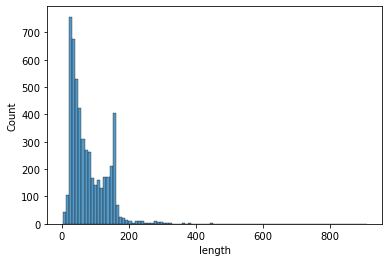

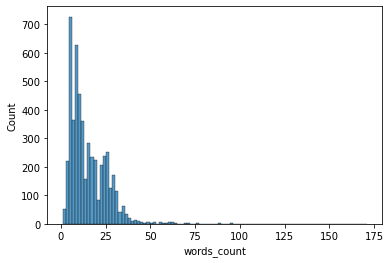

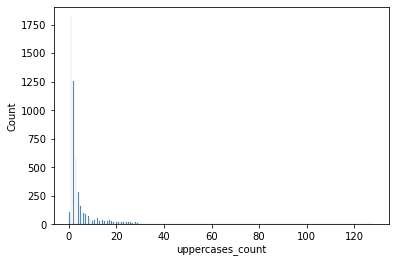

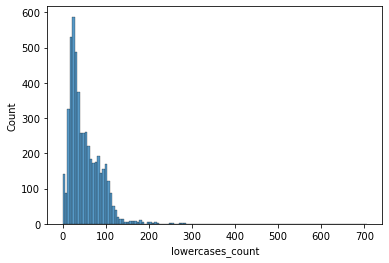

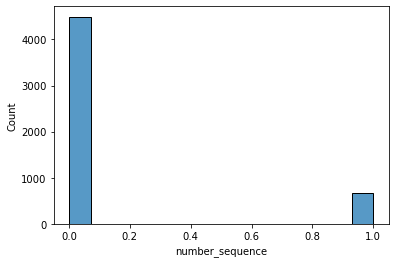

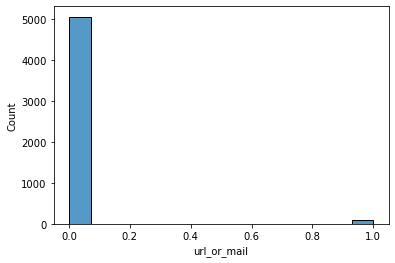

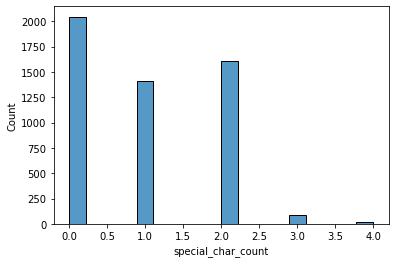

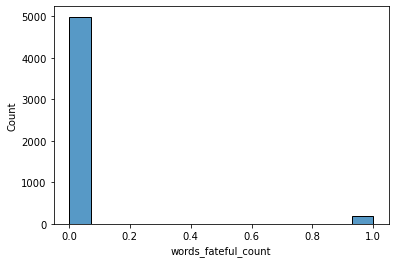

In [56]:
# Distribution
for col in df[df.columns.drop('target')]:
    plt.figure()
    sns.histplot(df[col])

In [57]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

transfo_num = Pipeline(steps=[('scaling', MinMaxScaler())])

# Pipeline ML <a class="anchor" id="pipeline_ml"></a>

In [58]:
from sklearn.compose import ColumnTransformer

# Class ColumnTransformer : apply alls steps on the whole dataset
preparation = ColumnTransformer(transformers=[('data_num', transfo_num , column_num)])

In [59]:
from sklearn.tree import DecisionTreeClassifier

# Creation of model : a ready to use pipeline for ML process
model = DecisionTreeClassifier(max_depth=5)
pipe_model = Pipeline(steps=[
    ('preparation', preparation),
    ('model',model)
])
pipe_model

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('data_num',
                                                  Pipeline(steps=[('scaling',
                                                                   MinMaxScaler())]),
                                                  ['length', 'words_count',
                                                   'uppercases_count',
                                                   'lowercases_count',
                                                   'special_char_count',
                                                   'words_fateful_count'])])),
                ('model', DecisionTreeClassifier(max_depth=5))])

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [61]:
pipe_model.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('data_num',
                                                  Pipeline(steps=[('scaling',
                                                                   MinMaxScaler())]),
                                                  ['length', 'words_count',
                                                   'uppercases_count',
                                                   'lowercases_count',
                                                   'special_char_count',
                                                   'words_fateful_count'])])),
                ('model', DecisionTreeClassifier(max_depth=5))])

### Prédiction <a class="anchor" id="prediction"></a>

In [62]:
y_pred = pipe_model.predict(X_test)

In [63]:
from sklearn.metrics import accuracy_score
# Score of models
score = accuracy_score(y_test, y_pred)
print("score :", round(score, 5))

score : 0.94681


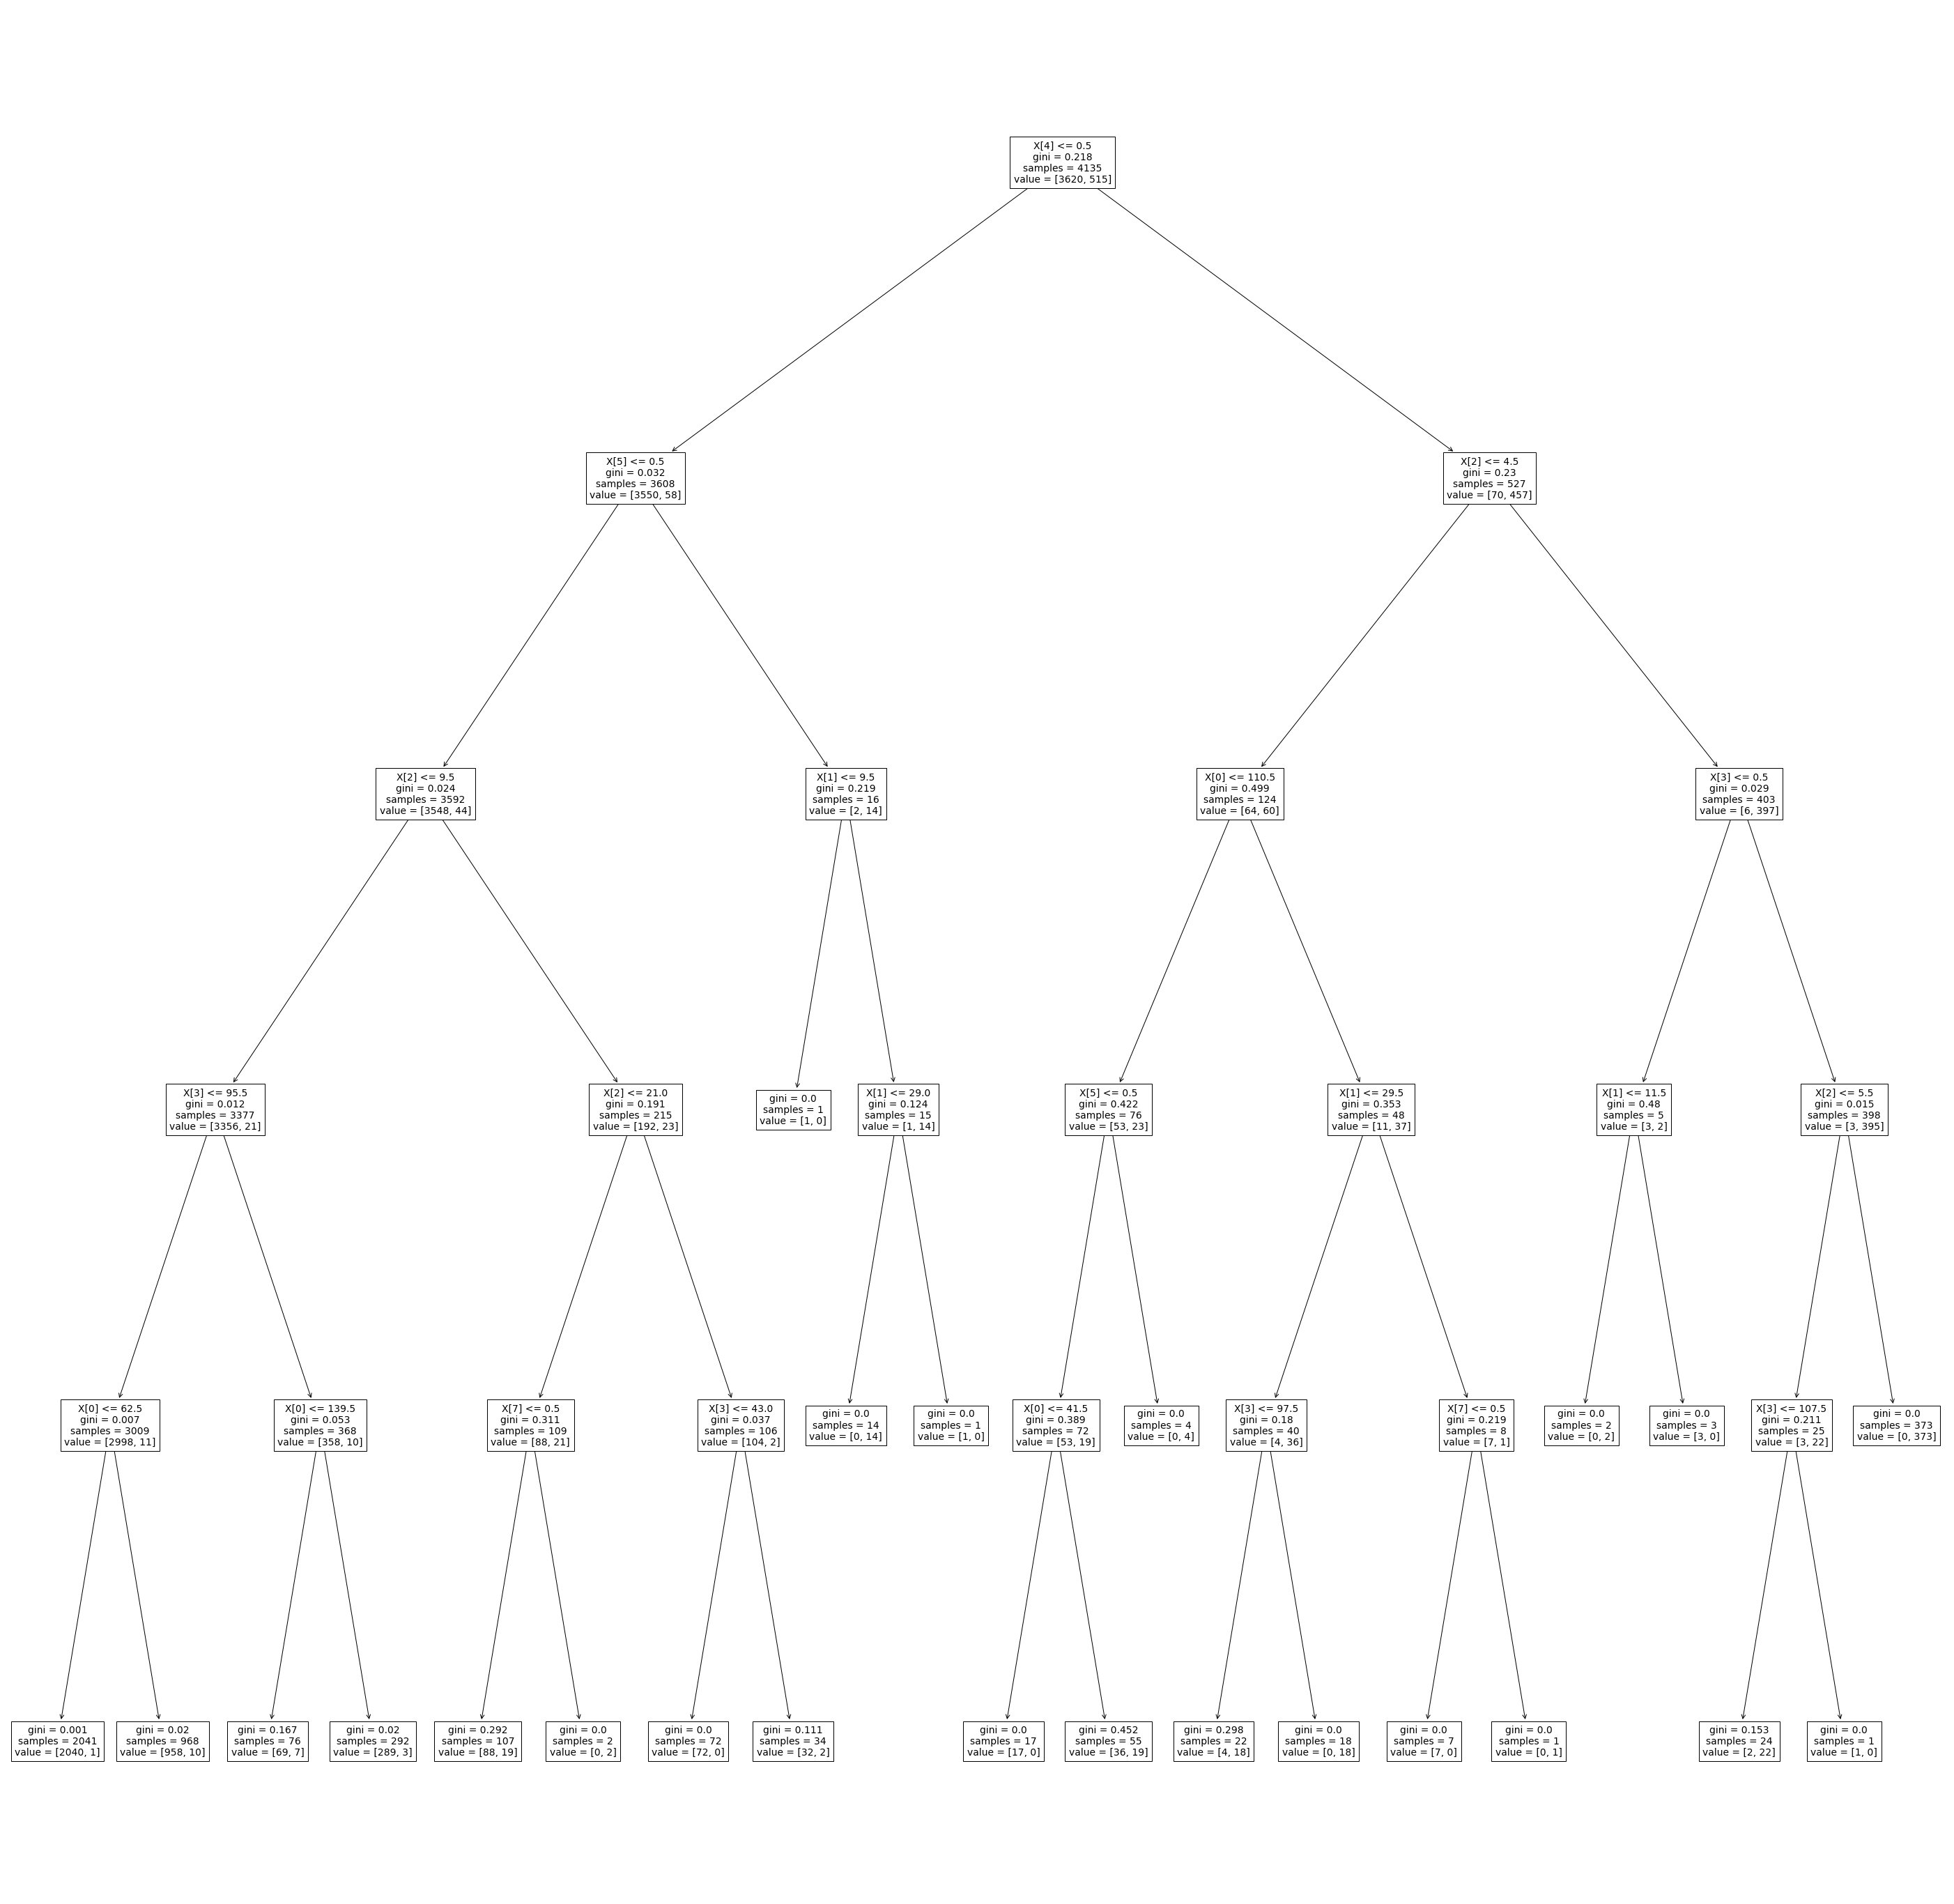

In [87]:
from sklearn import tree
# Step 1: Import the model you want to use
# This was already imported earlier in the notebook so commenting out
# Step 2: Make an instance of the Model
clf = tree.DecisionTreeClassifier(max_depth = 5)
# Step 3: Train the model on the data
clf.fit(X_train, y_train)
# Step 4: Predict labels of unseen (test) data
# Not doing this step in the tutorial
# clf.predict(X_test)

plt.figure( figsize=(50,50))
tree.plot_tree(clf);

In [88]:
X_train.columns

Index(['length', 'words_count', 'uppercases_count', 'lowercases_count',
       'number_sequence', 'url_or_mail', 'special_char_count',
       'words_fateful_count'],
      dtype='object')

In [72]:
#Export de l'arbre

from sklearn.tree import export_graphviz

export_graphviz(
    pipe_model,
    out_file=None,
    feature_names=df.columns[1:],
    class_names='target',
    rounded=True,
    filled=True
)

AttributeError: 'Pipeline' object has no attribute 'tree_'